In [376]:
import requests
import re
import time
import pandas as pd
from matplotlib import pyplot as plt

In [363]:
sleep_time = 7
keyword_matches = [
    "Showing (\d*\,?\d*) available\n      commit result",
    "(\d*\,?\d*) available commit result",
    "(\d*\,?\d*) commit result"
]
total_count_matches = [
    "(\d*\,?\d*)\n            \<\/span\>\n            commit",
]
no_commits_matching = ["We couldn’t find any commits"]
closed_issues = ["(\d*\,?\d*) Closed"]

In [ ]:
last_response = None
response_cache = {}

In [365]:
# Search keyword through commits
def cached_request(url):
    global sleep_time
    global response_cache
    global last_response
    
    if url in response_cache and response_cache[url].status_code == 200:
        response = response_cache[url]
    else:
        time.sleep(sleep_time)
        response = requests.get(url)
    
    last_response = response
    if response.status_code != 200:
        sleep_time *= 1.62
        print(f"Got status_code {response.status_code}. Sleeping more: {sleep_time} seconds.")
        print(response.text)
    else:
        response_cache[url] = response
        
    return response

def match(txt, match_list):
    matches = [re.search(kw, txt) for kw in match_list]
    matches = [m for m in matches if m]  # Reject nonmatches
    if not matches:
        with open('test.html', 'w') as f:
            f.write(txt)
            print("No match found. Check response in 'test.html', or look at global last_response or response_cache.")
    return matches

def query_commits(query, project):
    """
    query: text that commits must contain
    project: the URL of the main page of the project
    """
    
    if query == 'all':
        response = cached_request(project)
        matches = match(response.text, total_count_matches)
    elif query == 'issues/bug':
        response = cached_request(f"{project}/issues?q=is%3Aissue+is%3Aclosed+label%3Abug")
        matches = match(response.text, closed_issues)
    else:
        response = cached_request(f"{project}/search?q={query}&type=Commits")
        matches = match(response.text, keyword_matches)
    try:
        return int(matches[0].groups()[0].replace(',', ''))
    except IndexError:
        if match(response.text, no_commits_matching):
            return 0
        else:
            raise

In [554]:
# Searching through commits: Add is synonymous with adds and added, and fix with fixes, but NOT with fixed
# Excluded Django because of “Fixes” commit syntax even for adding features
# Rules (might have made mistakes): 
# * Search repos for the language name (exception: just "notebook" for Jupyter Notebook)
# * sort by most forks
# * eliminate exercise or collection projects for learning
# * eliminate where commit message language is not English
# * eliminate where main prog lang is <75%
# * eliminate where <200 commits (changed later, because not enough Mathematica repos; might have missed other languages' repos)
# * eliminate more than one project per language from the same account
# * try to avoid projects with many commits like https://bugzilla.mozilla.org/show_bug.cgi (found as "bugs" even if features)
# * avoid projects with commit mesages like "[x] I added an entry to the `CHANGELOG.md` for any breaking changes, enhancements, or bug fixes."
# * try to get 20 of each language (could not find enough non-learning non-collection Jupyter Notebook or Mathematica projects)


projects = pd.read_csv('commits.csv').dropna(subset=['lang']).set_index('proj')
projects.fillna(0).groupby('lang').count().sort_values('all')

,all,fix OR fixed OR bug
lang,,
Jupyter Notebook,10,10
Mathematica,11,11
C++,19,19
Lua,19,19
Scala,20,20
Ruby,20,20
R,20,20
PHP,20,20
Matlab,20,20


In [555]:
for project in projects.index:
    for query in projects.columns:
        if query != 'lang':
            if pd.isnull(projects.loc[project, query]):
                projects.loc[project, query] = query_commits(query, project)
                print(f"Fetched ({project}, {query}) = {projects.loc[project, query]}")
            else:
                print(f"Skipped ({project}, {query}) = {projects.loc[project, query]}")
projects.to_csv('commits_filled.csv')

Fetched (https://github.com/akheron/jansson, all) = 986.0
Fetched (https://github.com/akheron/jansson, fix OR fixed OR bug) = 235.0
Fetched (https://github.com/aquynh/capstone, all) = 4101.0
Fetched (https://github.com/aquynh/capstone, fix OR fixed OR bug) = 1140.0
Fetched (https://github.com/asterisk/asterisk, all) = 32350.0
Fetched (https://github.com/asterisk/asterisk, fix OR fixed OR bug) = 10249.0
Fetched (https://github.com/cloudwu/pbc, all) = 207.0
Fetched (https://github.com/cloudwu/pbc, fix OR fixed OR bug) = 29.0
Fetched (https://github.com/curl/curl, all) = 25029.0
Fetched (https://github.com/curl/curl, fix OR fixed OR bug) = 6582.0
Fetched (https://github.com/edenhill/librdkafka, all) = 3278.0
Fetched (https://github.com/edenhill/librdkafka, fix OR fixed OR bug) = 680.0
Fetched (https://github.com/glfw/glfw, all) = 3982.0
Fetched (https://github.com/glfw/glfw, fix OR fixed OR bug) = 1005.0
Fetched (https://github.com/jonas/tig, all) = 2583.0
Fetched (https://github.com/jona

Fetched (https://github.com/clojure/clojurescript, fix OR fixed OR bug) = 692.0
Fetched (https://github.com/dakrone/clojure-opennlp, all) = 313.0
Fetched (https://github.com/dakrone/clojure-opennlp, fix OR fixed OR bug) = 48.0
Fetched (https://github.com/Day8/re-frame, all) = 2013.0
Fetched (https://github.com/Day8/re-frame, fix OR fixed OR bug) = 277.0
Fetched (https://github.com/korma/Korma, all) = 491.0
Fetched (https://github.com/korma/Korma, fix OR fixed OR bug) = 96.0
Fetched (https://github.com/LauJensen/clojureql, all) = 305.0
Fetched (https://github.com/LauJensen/clojureql, fix OR fixed OR bug) = 54.0
Fetched (https://github.com/LightTable/LightTable, all) = 1263.0
Fetched (https://github.com/LightTable/LightTable, fix OR fixed OR bug) = 276.0
Fetched (https://github.com/metosin/spec-tools, all) = 698.0
Fetched (https://github.com/metosin/spec-tools, fix OR fixed OR bug) = 127.0
Fetched (https://github.com/metrics-clojure/metrics-clojure, all) = 436.0
Fetched (https://github.c

Fetched (https://github.com/haskell/hackage-server, all) = 1855.0
Fetched (https://github.com/haskell/hackage-server, fix OR fixed OR bug) = 309.0
Fetched (https://github.com/haskell/network, all) = 1304.0
Fetched (https://github.com/haskell/network, fix OR fixed OR bug) = 181.0
Fetched (https://github.com/jaspervdj/hakyll, all) = 1837.0
Fetched (https://github.com/jaspervdj/hakyll, fix OR fixed OR bug) = 244.0
Fetched (https://github.com/jgm/pandoc, all) = 12974.0
Fetched (https://github.com/jgm/pandoc, fix OR fixed OR bug) = 1828.0
Fetched (https://github.com/koalaman/shellcheck, all) = 1404.0
Fetched (https://github.com/koalaman/shellcheck, fix OR fixed OR bug) = 318.0
Fetched (https://github.com/ndmitchell/hlint, all) = 3559.0
Fetched (https://github.com/ndmitchell/hlint, fix OR fixed OR bug) = 344.0
Fetched (https://github.com/phadej/github, all) = 795.0
Fetched (https://github.com/phadej/github, fix OR fixed OR bug) = 78.0
Fetched (https://github.com/PostgREST/postgrest, all) = 1

Fetched (https://github.com/pixiedust/pixiedust, fix OR fixed OR bug) = 248.0
Fetched (https://github.com/QuantEcon/QuantEcon.notebooks, all) = 212.0
Fetched (https://github.com/QuantEcon/QuantEcon.notebooks, fix OR fixed OR bug) = 32.0
Fetched (https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python, all) = 1278.0
Fetched (https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python, fix OR fixed OR bug) = 359.0
Fetched (https://github.com/rsvp/fecon235, all) = 304.0
Fetched (https://github.com/rsvp/fecon235, fix OR fixed OR bug) = 35.0
Fetched (https://github.com/afollestad/material-dialogs, all) = 1980.0
Fetched (https://github.com/afollestad/material-dialogs, fix OR fixed OR bug) = 360.0
Fetched (https://github.com/anthonycr/Lightning-Browser, all) = 2112.0
Fetched (https://github.com/anthonycr/Lightning-Browser, fix OR fixed OR bug) = 415.0
Fetched (https://github.com/arturbosch/detekt, all) = 2719.0
Fetched (https://github.com/arturbosch/detekt, fix OR fixed OR bug) = 

Fetched (https://github.com/petercorke/robotics-toolbox-matlab, fix OR fixed OR bug) = 209.0
Fetched (https://github.com/plotly/plotly-graphing-library-for-matlab, all) = 823.0
Fetched (https://github.com/plotly/plotly-graphing-library-for-matlab, fix OR fixed OR bug) = 213.0
Fetched (https://github.com/rodralez/NaveGo, all) = 307.0
Fetched (https://github.com/rodralez/NaveGo, fix OR fixed OR bug) = 2.0
Fetched (https://github.com/sccn/eeglab, all) = 12512.0
Fetched (https://github.com/sccn/eeglab, fix OR fixed OR bug) = 2166.0
Fetched (https://github.com/scottclowe/matlab-schemer, all) = 243.0
Fetched (https://github.com/scottclowe/matlab-schemer, fix OR fixed OR bug) = 21.0
Fetched (https://github.com/SheffieldML/GPmat, all) = 1959.0
Fetched (https://github.com/SheffieldML/GPmat, fix OR fixed OR bug) = 173.0
Fetched (https://github.com/votchallenge/vot-toolkit, all) = 861.0
Fetched (https://github.com/votchallenge/vot-toolkit, fix OR fixed OR bug) = 227.0
Fetched (https://github.com/

Fetched (https://github.com/PHPMailer/PHPMailer, all) = 1571.0
Fetched (https://github.com/PHPMailer/PHPMailer, fix OR fixed OR bug) = 275.0
Fetched (https://github.com/phpmetrics/PhpMetrics, all) = 764.0
Fetched (https://github.com/phpmetrics/PhpMetrics, fix OR fixed OR bug) = 204.0
Fetched (https://github.com/phpmyadmin/phpmyadmin, all) = 116954.0
Fetched (https://github.com/phpmyadmin/phpmyadmin, fix OR fixed OR bug) = 11039.0
Fetched (https://github.com/PHPOffice/PhpSpreadsheet, all) = 2131.0
Fetched (https://github.com/PHPOffice/PhpSpreadsheet, fix OR fixed OR bug) = 566.0
Fetched (https://github.com/phpseclib/phpseclib, all) = 3558.0
Fetched (https://github.com/phpseclib/phpseclib, fix OR fixed OR bug) = 633.0
Fetched (https://github.com/pubnub/php, all) = 407.0
Fetched (https://github.com/pubnub/php, fix OR fixed OR bug) = 82.0
Fetched (https://github.com/sebastianbergmann/phpunit, all) = 12836.0
Fetched (https://github.com/sebastianbergmann/phpunit, fix OR fixed OR bug) = 1875.

Fetched (https://github.com/mongodb/mongoid, fix OR fixed OR bug) = 1584.0
Fetched (https://github.com/oneclick/rubyinstaller, all) = 924.0
Fetched (https://github.com/oneclick/rubyinstaller, fix OR fixed OR bug) = 58.0
Fetched (https://github.com/opal/opal, all) = 7171.0
Fetched (https://github.com/opal/opal, fix OR fixed OR bug) = 1442.0
Fetched (https://github.com/plataformatec/devise, all) = 3634.0
Fetched (https://github.com/plataformatec/devise, fix OR fixed OR bug) = 558.0
Fetched (https://github.com/pubnub/ruby, all) = 768.0
Fetched (https://github.com/pubnub/ruby, fix OR fixed OR bug) = 167.0
Fetched (https://github.com/rack/rack, all) = 2575.0
Fetched (https://github.com/rack/rack, fix OR fixed OR bug) = 420.0
Fetched (https://github.com/rails/rails, all) = 75204.0
Fetched (https://github.com/rails/rails, fix OR fixed OR bug) = 14852.0
Fetched (https://github.com/rmosolgo/graphql-ruby, all) = 5170.0
Fetched (https://github.com/rmosolgo/graphql-ruby, fix OR fixed OR bug) = 107

Fetched (https://github.com/KittyKatt/screenFetch, fix OR fixed OR bug) = 438.0
Fetched (https://github.com/licess/lnmp, all) = 756.0
Fetched (https://github.com/licess/lnmp, fix OR fixed OR bug) = 153.0
Fetched (https://github.com/lukas2511/dehydrated, all) = 569.0
Fetched (https://github.com/lukas2511/dehydrated, fix OR fixed OR bug) = 143.0
Fetched (https://github.com/nvm-sh/nvm, all) = 1852.0
Fetched (https://github.com/nvm-sh/nvm, fix OR fixed OR bug) = 453.0
Fetched (https://github.com/ohmyzsh/ohmyzsh, all) = 5387.0
Fetched (https://github.com/ohmyzsh/ohmyzsh, fix OR fixed OR bug) = 1006.0
Fetched (https://github.com/OpenVPN/easy-rsa, all) = 409.0
Fetched (https://github.com/OpenVPN/easy-rsa, fix OR fixed OR bug) = 91.0
Fetched (https://github.com/petervanderdoes/gitflow-avh, all) = 1183.0
Fetched (https://github.com/petervanderdoes/gitflow-avh, fix OR fixed OR bug) = 117.0
Fetched (https://github.com/pi-hole/pi-hole, all) = 3799.0
Fetched (https://github.com/pi-hole/pi-hole, fix

In [557]:
buggy = pd.concat(
    [
        projects['lang'],
        projects['fix OR fixed OR bug']/projects['all']
    ],
    axis=1
)
buggy.columns = ['lang', 'bugratio']
print(buggy.sort_values('bugratio').head(20))

                                                           lang  bugratio
proj                                                                     
https://github.com/rodralez/NaveGo                       Matlab  0.006515
https://github.com/b3m2a1/mathematica-BTools        Mathematica  0.008197
https://github.com/rich-iannone/DiagrammeR                    R  0.009725
https://github.com/brendanhay/amazonka                  Haskell  0.029315
https://github.com/TonnyL/PaperPlane                     Kotlin  0.032520
https://github.com/GuangchuangYu/hexSticker                   R  0.040909
https://github.com/rdpeng/filehash                            R  0.042857
https://github.com/rstudio/tensorflow                         R  0.043478
https://github.com/CISOfy/lynis                           Shell  0.045708
https://github.com/bungle/lua-resty-template                Lua  0.049407
https://github.com/desktop/desktop                   TypeScript  0.049728
https://github.com/JustArchiNET/ArchiS

In [560]:
# Sort by median bugfix frequency in language
sorted_bugratios = buggy.groupby('lang').median().sort_values('bugratio', ascending=False)
buggy = buggy\
    .join(sorted_bugratios, on='lang', rsuffix='langmean')\
    .sort_values('bugratiolangmean')\
    .drop('bugratiolangmean', axis=1)
buggy

,lang,bugratio
proj,,
https://github.com/windsteiger/Theorema,Mathematica,0.056213
https://github.com/QuantumUtils/quantum-utils-mathematica,Mathematica,0.277533
https://github.com/obstudio/ThuliumMusic-WL,Mathematica,0.135099
https://github.com/noahbenson/Neurotica,Mathematica,0.444444
https://github.com/mfroeling/QMRITools,Mathematica,0.224490
...,...,...
https://github.com/nestjs/nest,TypeScript,0.315301
https://github.com/NativeScript/NativeScript,TypeScript,0.360628
https://github.com/maximegris/angular-electron,TypeScript,0.236422


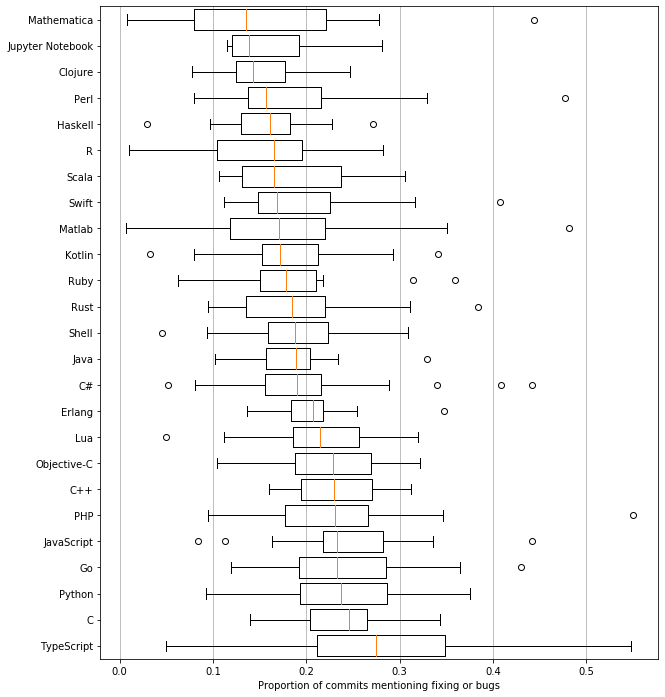

In [570]:
columns_my_order = sorted_bugratios.index
fig, ax = plt.subplots(figsize=(10, 12))
for position, lang in enumerate(columns_my_order):
    ax.boxplot(buggy.loc[buggy['lang'] == lang, 'bugratio'], positions=[position], vert=False, widths=0.8)

ax.grid(axis='x')
ax.set_yticklabels(columns_my_order)
ax.set_xlabel('Proportion of commits mentioning fixing or bugs')
plt.show()